# DS405 Machine Learning Applications in Business and Economics Mini-Project
---

<font color="red">TBD:



- Powerpoint slides
- Export of objects of interest for presentation: Graphs, Tables, ...


</font>

### Introduction

In the realm of e-commerce, a common observation is that a significant proportion of customers engage in a single transaction and then cease further purchases. \
 This phenomenon can be attributed to a multitude of factors. To mitigate this, e-commerce platforms employ a variety of strategies aimed at fostering customer loyalty. \
  One such strategy involves the distribution of discount vouchers subsequent to the initial purchase, with the goal of incentivizing repeat transactions. \
   However, indiscriminate distribution of these vouchers may not be an optimal strategy. This is because a segment of customers might have engaged in repeat purchases even in the absence of such incentives. Consequently, the redemption of these vouchers by such customers translates into a reduction in the retailer’s profit. \
   Empirical analyses conducted by the media retailer have demonstrated that for 10% of non-buyers, the voucher instigates a purchase with an average order value of €20. Thus, if a voucher is dispatched to a customer who would not have actually made another purchase, the revenue increases by an average of €1.5. \
    On the other hand, sending a voucher to a customer who would have made a purchase anyway results in a revenue loss equivalent to the voucher value of €5. For customers who don’t receive a voucher, there is no impact on revenues. Therefore, it is crucial to devise a more targeted approach for the distribution of these vouchers.

### Task

The task at hand involves **constructing a predictive model** that leverages various features associated with a customer’s initial order. \
 The objective is to **determine whether a €5.00 voucher should be issued to a specific customer**. Detailed descriptions of these features can be found in the data dictionary.pdf file. \
The model should be **designed to predict if a customer will place a subsequent order within a 90-day period** following their initial purchase. This information is represented by the target90 variable in the dataset. \
 The model’s performance is evaluated based on the expected revenue across all customers in a given dataset. This is computed by considering the model’s predictions in conjunction with the associated costs and revenues. \
  It’s crucial to note that the model’s effectiveness is directly tied to its ability to maximize this expected revenue. Hence, the model should be optimized with this specific goal in mind.


---

In [29]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Binary dependent variable
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import joblib # to save trained model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import shap 
from sklearn.inspection import permutation_importance #
from sklearn.inspection import PartialDependenceDisplay as pdp 
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import plot_tree
from lime import lime_tabular
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [30]:
# Separator is ; 
data = pd.read_csv("train.csv", sep = ";")

# Set seed for reproducibility
seed = 1

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.


Get a glimpse at the data to check variable types and size of dataset

In [31]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32428 entries, 0 to 32427
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customernumber        32428 non-null  int64 
 1   date                  32428 non-null  object
 2   salutation            32428 non-null  int64 
 3   title                 32428 non-null  int64 
 4   domain                32428 non-null  int64 
 5   datecreated           32428 non-null  object
 6   newsletter            32428 non-null  int64 
 7   model                 32428 non-null  int64 
 8   paymenttype           32428 non-null  int64 
 9   deliverytype          32428 non-null  int64 
 10  invoicepostcode       32428 non-null  int64 
 11  delivpostcode         1392 non-null   object
 12  voucher               32428 non-null  int64 
 13  advertisingdatacode   6523 non-null   object
 14  case                  32428 non-null  int64 
 15  numberitems           32428 non-null

In [32]:
# Function to check for NAs in every column
def count_na(df):
    for col in df.columns:          # Loop over all columns
        n_na = df[col].isna().sum() # Count occurrences of missing values
        if n_na > 0:                # Only give column and count if there actually are NAs
            print(col, n_na)        # Print column name and number of NAs

# Apply function
count_na(data)

delivpostcode 31036
advertisingdatacode 25905


Since *delivpostcode* contains a considerable amount of missing values, imputing the *invoicepostcode* might be a valid approach. Therefore, we further investigate the *invoicepostcode* column.


In [33]:
print(data['invoicepostcode'].unique())
print(f"Number of unique observations in invoicepostcode: {len(data['invoicepostcode'].unique())}.")

[58 34 51 25 41 95 78 77 86 97 50 40 99 85 88 17 70 30 68 15 12 63 18 89
 49 20 42 21 73 22 55 23  7 65 79 57 46 27 10 52 66 91 24 74 61 56 76 38
 26 32 39 84 29 33  1 16 13 80  2 14 45 81 53 90 60  3 64 54 71 28 36 67
 44 31 47 35  9  4 69 59 92 93 37 48 94 96 72 83 75  8 82  6 87 19 98 11
  0]
Number of unique observations in invoicepostcode: 97.


---

## Visualization of feature distribution

In [34]:
# Gather caterogical and continuous features in separate lists
cat_features = ["salutation", "title", "domain", "newsletter", "model", "paymenttype", "deliverytype",
                     "voucher", "case", "gift", "entry", "points", "shippingcosts", "invoicepostcode"] # target90
cntnous_features = ["numberitems", "weight", "remi", "cancel", "used", "w0", "w1", "w2", "w3", "w4", "w5", "w6", "w7", "w8", "w9", "w10"]

In [35]:
len(cat_features + cntnous_features)

30

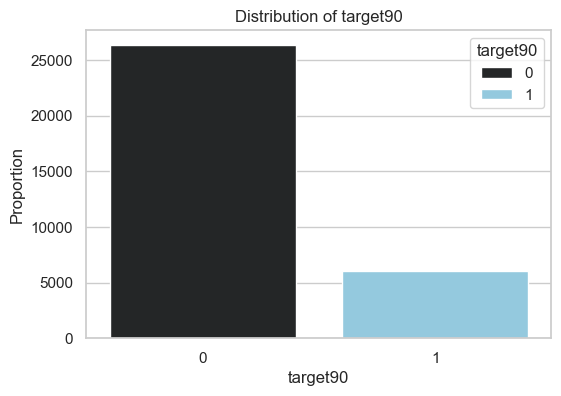

Only 18.66% of customers in the data set repurchased in the next 90 days. This makes the data set imbalanced and we have to proceed with caution.


In [109]:
# Draw distribution of target90 variable in data
plt.figure(figsize=(6, 4))

# Create barplot of distribution of target90 in data
sns.countplot(x='target90', data=data, hue='target90', palette='dark:skyblue')

plt.title("Distribution of target90")
plt.xlabel('target90')
plt.ylabel('Proportion')
plt.savefig("target90.png")
plt.show()

print(f"Only {np.round(data['target90'].mean()*100, 2)}% of customers in the data set repurchased in the next 90 days. This makes the data set imbalanced and we have to proceed with caution.")

- Distribution of nominal features with respect to target90

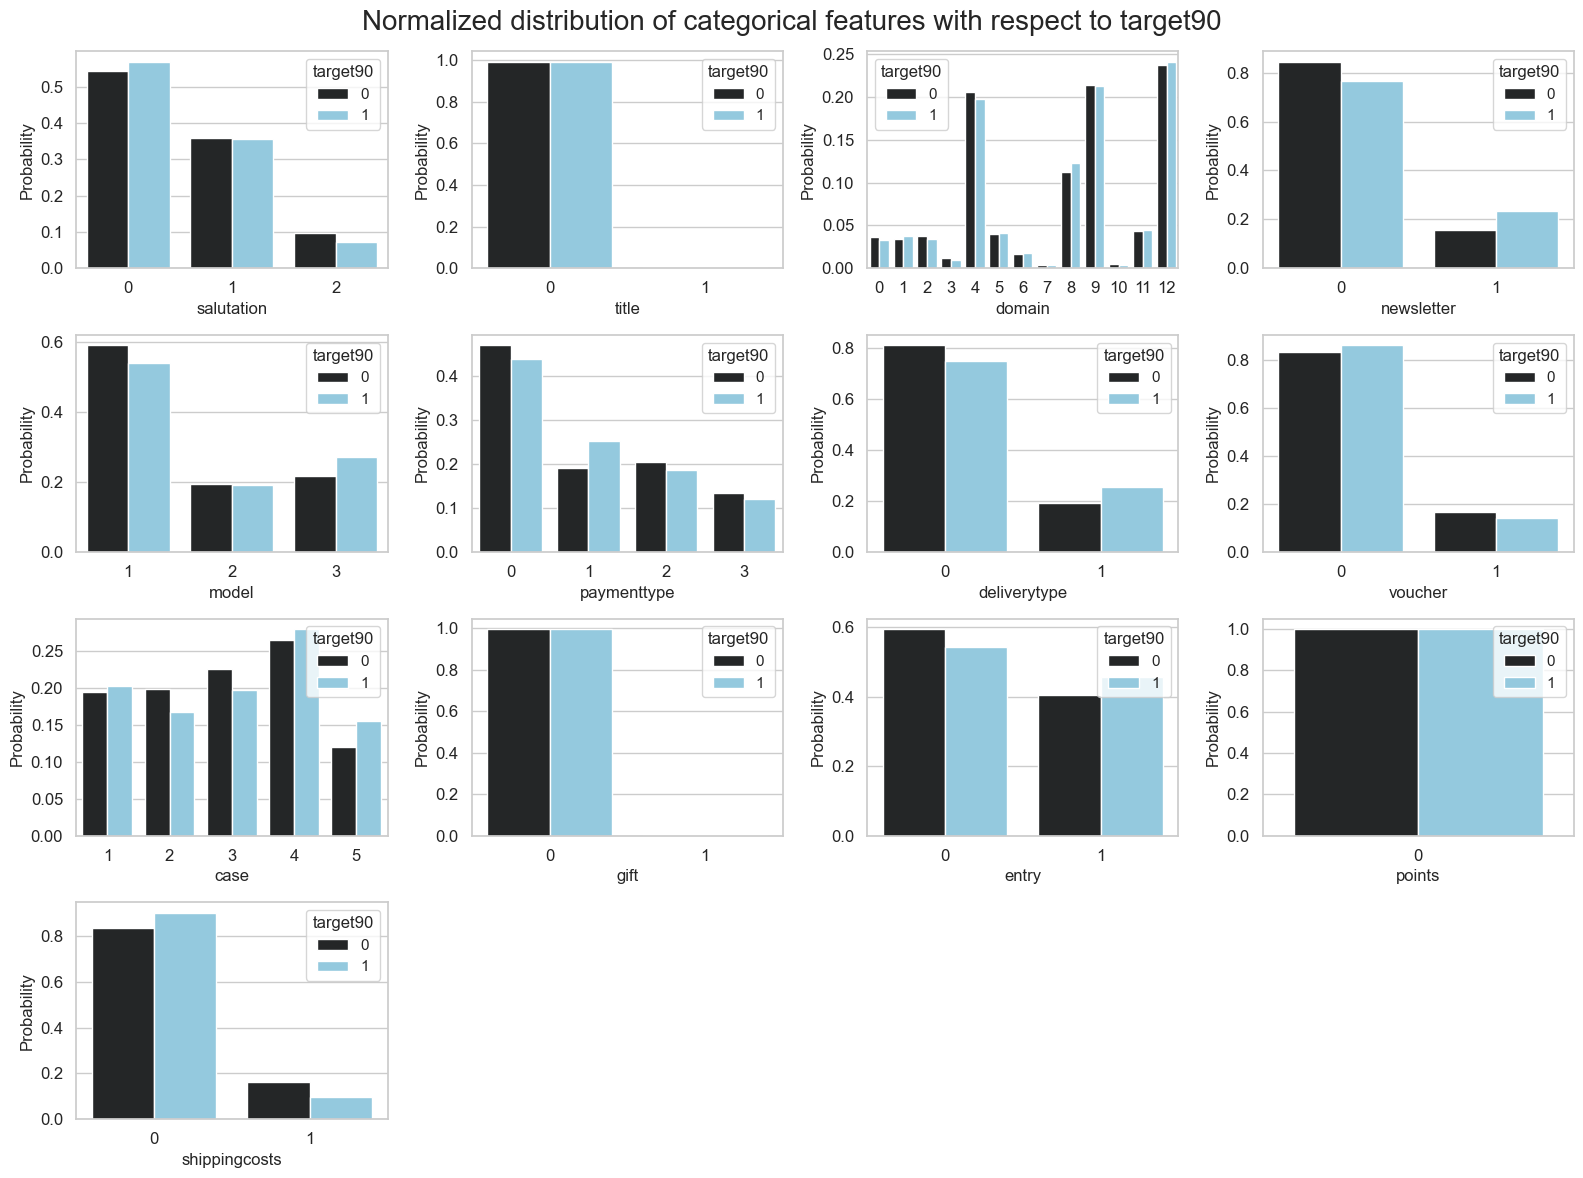

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each nominal feature and create bar plots
for i, feature in enumerate(cat_features):
    # Count the occurrences of each combination of 'target90' and the current column
    counts = data.groupby(['target90', feature]).size().reset_index(name='count')
    # Normalize the counts for each hue category
    counts['count'] /= counts.groupby('target90')['count'].transform('sum')

    # Plot the normalized count plot using seaborn
    sns.barplot(x=feature, y='count', hue='target90', data=counts, palette='dark:skyblue', ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Probability')
    axes[i].legend(title='target90')
    axes[i].tick_params(axis='both', labelsize=12)

# Add an overall title
fig.suptitle('Normalized distribution of categorical features with respect to target90', fontsize=20)
axes[13].set_visible(False) # hide empty subplots
axes[14].set_visible(False)
axes[15].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('cat_features.png')
plt.show()

The graphs above show the normalized distribution of the target90 variable within each feature. This allows us to more easily identify changes in the underlying distributions within, as well as in between the different features. Ultimately, this can help identify potentially impactful features for the classification class at hand. 

The invoicepostcode graph below follows the same logic.

- Visualization of invoicepostcode

    Since the *invoicepostcode* variable has 97 different values, we only focus on the 20 most frequent ones and plot them separately, in order to achieve better readability.

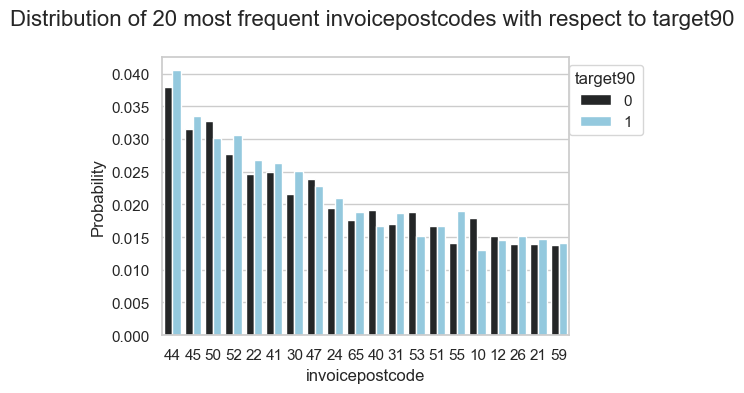

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose the categorical feature to plot
feature = 'invoicepostcode'  

# Count the occurrences of each combination of 'target90' and the chosen categorical column
counts = data.groupby(['target90', feature]).size().reset_index(name='count')
# Normalize the counts for each hue category
counts['count'] /= counts.groupby('target90')['count'].transform('sum')

# Get the top 20 categories by frequency
top_categories = counts.groupby(feature)['count'].sum().sort_values(ascending=False).head(20).index

# Filter the counts dataframe for the top 20 categories
counts_top20 = counts[counts[feature].isin(top_categories)]

# Create a single subplot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the normalized count plot using seaborn
sns.barplot(x=feature, y='count', hue='target90', data=counts_top20, palette='dark:skyblue', ax=ax, order=top_categories)
ax.set_xlabel(feature)
ax.set_ylabel('Probability')
ax.legend(title='target90', loc='upper right', bbox_to_anchor=(1.2, 1))

# Add an overall title
fig.suptitle('Distribution of 20 most frequent invoicepostcodes with respect to target90', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [39]:
# Save the plot
plt.savefig('distr_feature_targetclass.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

- Distribution of continuous features with respect to target90

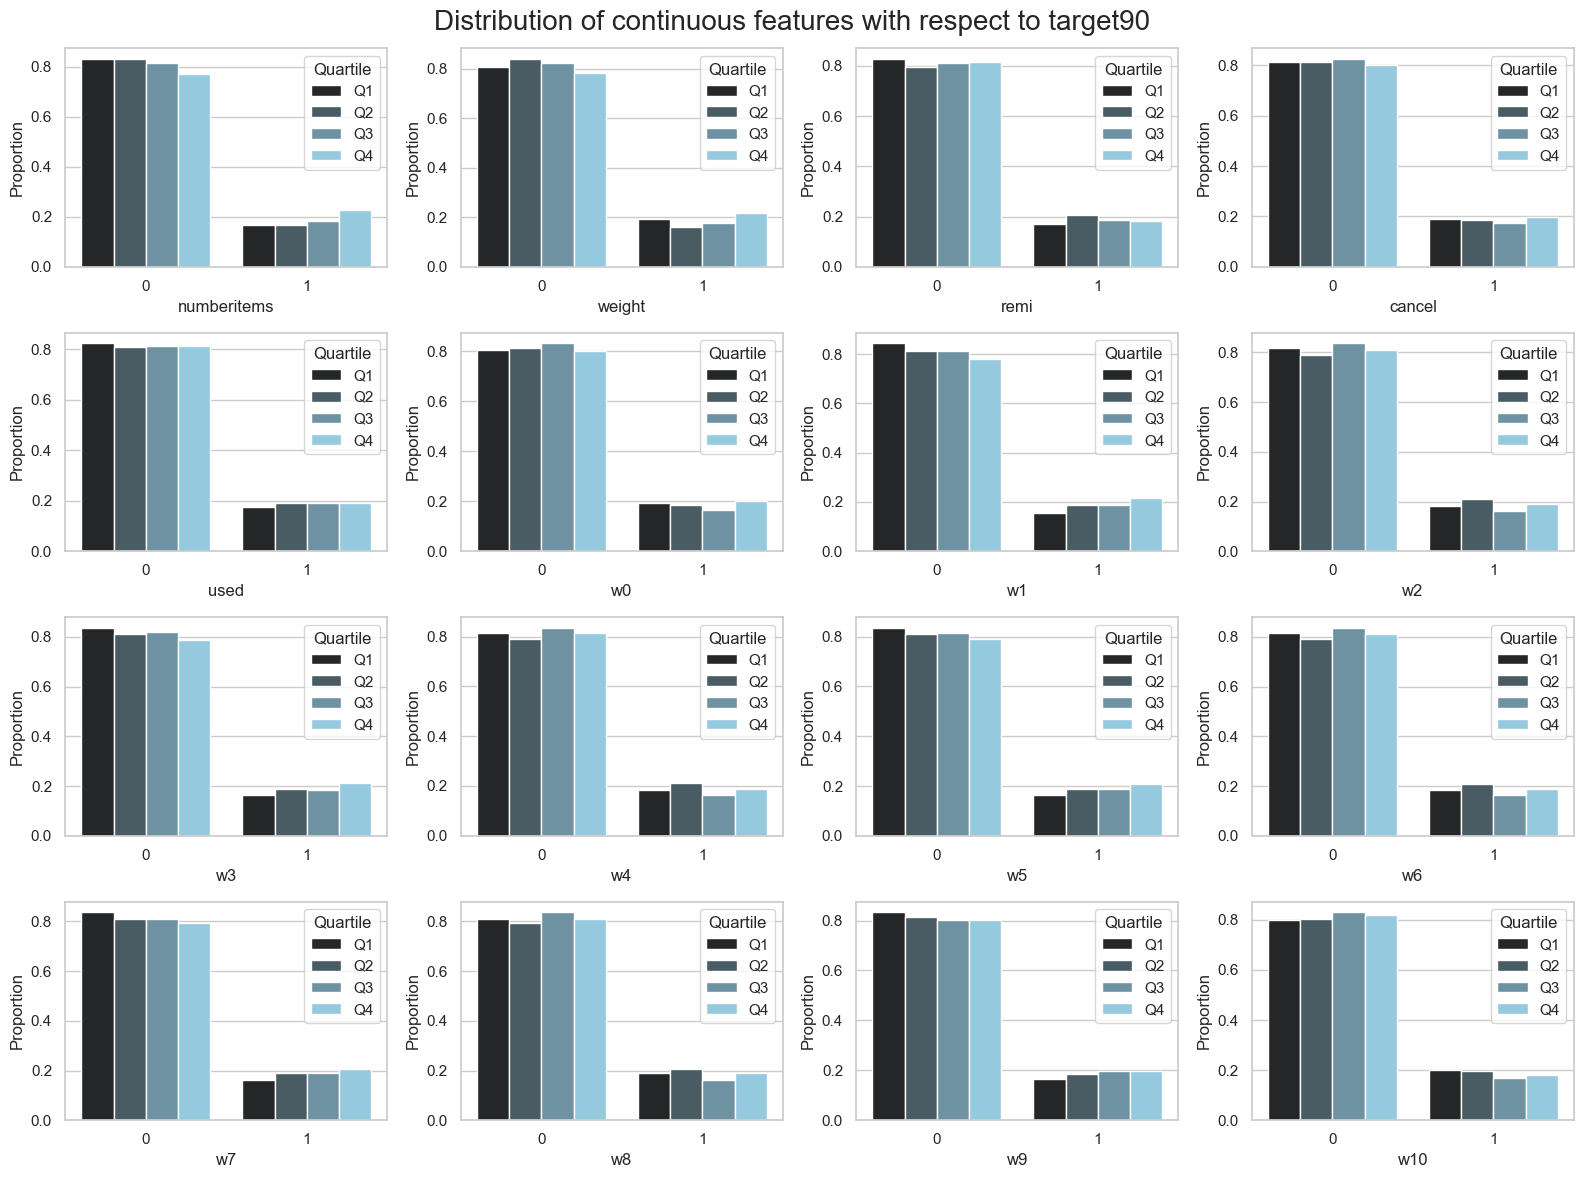

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each nominal feature and create countplots for quartiles
for i, feature in enumerate(cntnous_features):

    # Sort data according to feature
    data = data.sort_values(feature)

    # Get data in 25% slides
    data_25 = data.iloc[:int(0.25 * len(data))]
    data_50 = data.iloc[int(0.25 * len(data)):int(0.5 * len(data))]
    data_75 = data.iloc[int(0.5 * len(data)):int(0.75 * len(data))]
    data_100 = data.iloc[int(0.75 * len(data)):]

    # Compute share of target90 = 1 in each quartile
    data_25_y_1 = data_25['target90'].mean()
    data_50_y_1 = data_50['target90'].mean()
    data_75_y_1 = data_75['target90'].mean()
    data_100_y_1 = data_100['target90'].mean()

    # Compute share of target90 = 0 in each quartile
    data_25_y_0 = 1 - data_25_y_1
    data_50_y_0 = 1 - data_50_y_1
    data_75_y_0 = 1 - data_75_y_1
    data_100_y_0 = 1 - data_100_y_1

    # Create a DataFrame with the computed values
    df = pd.DataFrame({'target90': ['0', '1'], 'Q1': [data_25_y_0, data_25_y_1], 'Q2': [data_50_y_0, data_50_y_1],
                        'Q3': [data_75_y_0, data_75_y_1], 'Q4': [data_100_y_0, data_100_y_1]})
    # Plot the results
    sns.barplot(x='target90', y='value', hue='variable', data=pd.melt(df, ['target90']), ax=axes[i], palette= 'dark:skyblue')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Quartile')
fig.suptitle('Distribution of continuous features with respect to target90', fontsize=20)


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Since some of the continuous features showed extreme outliers, we formed quartiles and plotted the proportional distribution of target90 within the respective quartiles. 
This allows to more easily identify whether a shift in the distribution of (non-)returning customers occurs in between the quartiles. For example, the more audiobooks (w5) people order, the more likely they seem to repurchase within the 90-day limit.

- Further descriptives and outlier detection

In [41]:
# Summary function for numerical features
def summary(data):
    stats_list = []

    for col in data.columns:
        if data[col].dtype in ['int64', 'float64']:
            col_data = data[col]
            col_min = np.round(col_data.min(),2)
            col_max = np.round(col_data.max(),2)
            col_mean = np.round(col_data.mean(),2)
            col_median = np.round(col_data.median(),2)


            col_summary = pd.DataFrame({
                "Feature": [col],
                "Minimum": [col_min],
                "Maximum": [col_max],
                "Mean": [col_mean],
                "Median": [col_median]
            })

            # Append the summary DataFrame to the list
            stats_list.append(col_summary)
        else:
            print(f"Column {col} is not suited for these descriptives.")

    # Concatenate all individual summary DataFrames into a single DataFrame
    result = pd.concat(stats_list, ignore_index=True)

    # Set variable name as index
    result.set_index("Feature", inplace=True)

    return result


In [42]:
summary_data = data.drop(["customernumber", "salutation", "domain", "model", "paymenttype", "invoicepostcode", "case"], axis=1)
summary(summary_data)

Column date is not suited for these descriptives.
Column datecreated is not suited for these descriptives.
Column delivpostcode is not suited for these descriptives.
Column advertisingdatacode is not suited for these descriptives.
Column deliverydatepromised is not suited for these descriptives.
Column deliverydatereal is not suited for these descriptives.


,Minimum,Maximum,Mean,Median
Feature,,,,
title,0,1,0.01,0.0
newsletter,0,1,0.17,0.0
deliverytype,0,1,0.20,0.0
voucher,0,1,0.16,0.0
numberitems,1,50,2.02,1.0
gift,0,1,0.00,0.0
entry,0,1,0.41,0.0
points,0,0,0.00,0.0
shippingcosts,0,1,0.15,0.0


Unfortunately, since our data set contained extreme outliers in some variables, plotting the distribution did not lead to meaningful results. \
 Therefore, the table above serves as a way of illustrating these outliers. \
For example, looking at the weight column we can see that the mean is 637.29 but the median, which is less prone to outliers, is only 494. This can in parts be explained when regarding the maximum weight of 20076 which heavily shifts the mean in its direction. 

For the purpose of our underlying classification problem we decided to disregard the outlier problem, since we expect the models predictions to be rather robust to outliers. 

---

## Data preprocessing

#### Computing delivery delay

We expect a potential delay in the delivery to have a systematic influence on a customer's re-purchase probability. The longer this delay gets, the less likely an expected re-purchase will occur.

- Filter rows with possibly invalid date-values

In [43]:
# Spot possible NaTs in date-variables
nat_date = pd.to_datetime(data['date'], errors='coerce')
nat_promised = pd.to_datetime(data['deliverydatepromised'], errors='coerce')
nat_real = pd.to_datetime(data['deliverydatereal'], errors='coerce')

In [44]:
# Filter rows with invalid date formats (NaT values)
inval_idx_date = data[nat_date.isnull()].index.tolist()
inval_idx_promised = data[nat_promised.isnull()].index.tolist()
inval_idx_real = data[nat_real.isnull()].index.tolist()

# Display incorrect entries of date as string columns
print("\nIncorrect entries of 'date':")
print(data.loc[inval_idx_date, 'date'])

print("\nIncorrect entries of 'deliverydatepromised':")
print(data.loc[inval_idx_promised, 'deliverydatepromised'])

print("\nIncorrect entries of 'deliverydatereal':")
print(data.loc[inval_idx_real, 'deliverydatereal'])


Incorrect entries of 'date':
Series([], Name: date, dtype: object)

Incorrect entries of 'deliverydatepromised':
28201    4746-11-18
23538    4746-05-08
14955    4746-07-23
16892    4746-06-13
23669    4746-05-15
15657    4746-11-26
26727    4746-11-15
27202    4746-10-01
23111    4746-11-15
Name: deliverydatepromised, dtype: object

Incorrect entries of 'deliverydatereal':
20526    0000-00-00
15446    0000-00-00
567      0000-00-00
31547    0000-00-00
28201    0000-00-00
            ...    
19596    0000-00-00
14206    0000-00-00
24750    0000-00-00
26156    0000-00-00
19576    0000-00-00
Name: deliverydatereal, Length: 5472, dtype: object


**deliverydatepromised:** 8 errors

**deliverydatereal:** 5472 errors


In [45]:
print(data.loc[inval_idx_promised, 'deliverydatepromised'], data.loc[inval_idx_promised, 'deliverydatereal'])

28201    4746-11-18
23538    4746-05-08
14955    4746-07-23
16892    4746-06-13
23669    4746-05-15
15657    4746-11-26
26727    4746-11-15
27202    4746-10-01
23111    4746-11-15
Name: deliverydatepromised, dtype: object 28201    0000-00-00
23538    0000-00-00
14955    2008-09-06
16892    2008-07-18
23669    2008-06-17
15657    2008-12-29
26727    0000-00-00
27202    2008-11-03
23111    2008-12-18
Name: deliverydatereal, dtype: object


- Replace incorrect 4746 by 2008 according to year of delivery real and convert to datetime

In [46]:
# Replace incorrect string for year:
data['deliverydatepromised'] = data['deliverydatepromised'].str.replace('4746', '2008')

# Convert date variables to dateformat:
data['date'] = pd.to_datetime(data['date'])
data['deliverydatepromised'] = pd.to_datetime(data['deliverydatepromised'])
data['deliverydatereal'] = pd.to_datetime(data['deliverydatereal'], errors='coerce')

- Build difference between 'promised' and 'real' and check for consistency

In [47]:
# Calculate difference between promised and real delivery dates (in days)
data['delivery_diff'] = (data['deliverydatereal'] - data['deliverydatepromised']).dt.days

# Explore 'delivery_diff'
print(data['delivery_diff'].describe())

count    26956.000000
mean       -17.260276
std         72.324342
min       -369.000000
25%         -3.000000
50%         -1.000000
75%         -1.000000
max        368.000000
Name: delivery_diff, dtype: float64


In [48]:
# Asses rows for which delivery_diff min(), max()
min_delivery_diff = data[data['delivery_diff'] == data['delivery_diff'].min()]
max_delivery_diff = data[data['delivery_diff'] == data['delivery_diff'].max()]

# Display rows for min and max delivery_diff
print("Rows with the minimum delivery_diff:")
print(min_delivery_diff[['date', 'deliverydatepromised', 'deliverydatereal', 'delivery_diff']].head(5))
print(len(min_delivery_diff[['date', 'deliverydatepromised', 'deliverydatereal', 'delivery_diff']]))

print("\nRows with the maximum delivery_diff:")
print(max_delivery_diff[['date', 'deliverydatepromised', 'deliverydatereal', 'delivery_diff']].head(5))
print(len(max_delivery_diff[['date', 'deliverydatepromised', 'deliverydatereal', 'delivery_diff']]))

Rows with the minimum delivery_diff:
            date deliverydatepromised deliverydatereal  delivery_diff
2023  2008-08-26           2009-08-31       2008-08-27         -369.0
14321 2008-05-14           2009-05-19       2008-05-15         -369.0
25875 2008-07-03           2009-07-07       2008-07-03         -369.0
22366 2008-04-15           2009-04-20       2008-04-16         -369.0
28601 2008-04-01           2009-04-06       2008-04-02         -369.0
52

Rows with the maximum delivery_diff:
            date deliverydatepromised deliverydatereal  delivery_diff
685   2008-04-02           2008-05-02       2009-05-05          368.0
19923 2008-06-19           2008-06-20       2009-06-23          368.0
2


- Further, check for observations for which 'promised' and 'real' fall within the first quarter of next year, but 'date' doesn't

    We want to extract the observations for which the Q1 statement is true and further spot those observations for which the year of promised and real date may not match.

In [49]:
# Create a new boolean column indicating whether promised and real fall within the first quarter
promised_q1 = data['deliverydatepromised'].dt.quarter == 1
real_q1 = data['deliverydatereal'].dt.quarter == 1

# Create a new boolean column indicating whether date doesn't fall within the first quarter
date_not_q1 = data['date'].dt.quarter != 1

# Filter rows where 'promised' and 'real' fall within the first quarter, but 'date' doesn't
dates_not_in_q1 = data[promised_q1 & real_q1 & date_not_q1]

# Observations for which the years between 'promised' and 'real' in Q1 differ/are incorrect
filtered_years_diff = dates_not_in_q1[dates_not_in_q1['deliverydatepromised'].dt.year != dates_not_in_q1['deliverydatereal'].dt.year]

# Display filtered df
print("Rows where 'promised' and 'real' fall within Q1, but 'date' doesn't and years differ:")
print(filtered_years_diff[['deliverydatepromised', 'deliverydatereal', 'date']])

Rows where 'promised' and 'real' fall within Q1, but 'date' doesn't and years differ:
      deliverydatepromised deliverydatereal       date
8024            2010-01-04       2009-03-13 2008-12-30
22219           2010-01-04       2009-01-15 2008-12-30
29881           2010-01-01       2009-03-31 2008-12-30
12129           2010-01-01       2009-02-13 2008-12-29
21813           2010-01-01       2009-01-08 2008-12-29
22968           2010-01-04       2009-01-24 2008-12-30
3709            2010-01-01       2009-03-27 2008-12-29
1196            2010-01-01       2009-01-03 2008-12-29
29373           2010-01-01       2009-01-02 2008-12-29
25921           2010-01-04       2009-01-02 2008-12-31
21727           2010-01-01       2009-03-07 2008-12-30
19087           2010-01-04       2009-03-07 2008-12-30
443             2010-01-04       2009-01-17 2008-12-30
28402           2010-01-05       2009-03-16 2008-12-31
28212           2010-01-05       2009-02-09 2008-12-31
5597            2010-01-05       2

**Note:** No adjustment of the year needed, as all entries are delayed anyway and 'delay' would be binary encoded. Therefore, we simply adjust the year of 'promised' according to 'date' and build the corrected delivery difference.

In [50]:
# Adjust the year of the promised date based on the year of the first order
data['adj_deliverydatepromised'] = data.apply(
    lambda row: row['deliverydatepromised'].replace(year=row['date'].year),
    axis=1
)

# Calculate difference between promised and real delivery dates (in days)
data['delivery_diff'] = (data['deliverydatereal'] - data['adj_deliverydatepromised']).dt.days
# 
print(data[['date', 'deliverydatepromised', 'deliverydatereal']].head())

print(f"\nNumber of missing values in delivery_diff: {data['delivery_diff'].isna().sum()}.")

            date deliverydatepromised deliverydatereal
27575 2008-09-07           2008-09-09       2008-09-08
15072 2008-09-23           2008-10-07       2008-09-25
15112 2008-07-27           2008-07-29       2008-07-28
16493 2008-12-20           2009-01-05       2008-12-27
26365 2008-06-08           2008-06-24       2008-07-25

Number of missing values in delivery_diff: 5472.


**Decision**: Despite considering delay as a promising new binary feature by utilizing the information from *delivery_diff*, we encountered 5472 missing values and were unable to devise a suitable imputation strategy. Therefore, we have decided to disregard this feature. 

### One hot encoding

In [51]:
# Split the dataframe into features and labels
y = data['target90']
x = data.drop('target90', axis=1)

# Split into train and test with stratified sampling to preserve class balances
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.3, random_state = seed)

# Pipeline for preprocessing of categorical features
preprocess_categorical = Pipeline(steps=[('encoder', OrdinalEncoder())])
# Pipeline for preprocessing of numerical features
preprocess_numerical = Pipeline(steps=[('scaler', MinMaxScaler())])
# Combine preprocessing steps
data_transformer = ColumnTransformer(transformers=[('categorical', preprocess_categorical, cat_features),
                                                   ('numerical', preprocess_numerical, cntnous_features)])
# Combine features
all_features = cat_features + cntnous_features

# Apply transformation to training and test data
x_train = pd.DataFrame(data_transformer.fit_transform(x_train), columns=all_features) # fit and transform data
x_test = pd.DataFrame(data_transformer.transform(x_test), columns=all_features) # only transform data

In [52]:
# Save transformer for use in model
joblib.dump(data_transformer, "data_transformer.joblib")

['data_transformer.joblib']

---

#### Further setup

- Function to evaluate model performance

In [53]:
def evaluate_model(y_train, y_train_pred, y_test, y_test_pred):

    # Convert y_train & y_test to np.array, as predictions will also be np.array
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Initialize variables for training set
    TP_train, FP_train, TN_train, FN_train = 0, 0, 0, 0

    # Initialize variables for test set
    TP_test, FP_test, TN_test, FN_train = 0, 0, 0, 0

    # Calculate training set scores
    TP_train = np.sum((y_train == 1) & (y_train_pred == 1))
    FP_train = np.sum((y_train == 0) & (y_train_pred == 1))
    TN_train = np.sum((y_train == 0) & (y_train_pred == 0))
    FN_train = np.sum((y_train == 1) & (y_train_pred == 0))

    # Calculate test set scores
    TP_test = np.sum((y_test == 1) & (y_test_pred == 1))
    FP_test = np.sum((y_test == 0) & (y_test_pred == 1))
    TN_test = np.sum((y_test == 0) & (y_test_pred == 0))
    FN_test = np.sum((y_test == 1) & (y_test_pred == 0))


    # Calculate training set metrics
    accuracy_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train) if (TP_train + TN_train + FP_train + FN_train) != 0 else 0
    precision_train = TP_train / (TP_train + FP_train) if (TP_train + FP_train) != 0 else 0
    sensitivity_train = TP_train / (TP_train + FN_train) if (TP_train + FN_train) != 0 else 0
    specificity_train = TN_train / (TN_train + FP_train) if (TN_train + FP_train) != 0 else 0
    f1_train = 2*TP_train / (2*TP_train + FP_train + FN_train) if (2*TP_train + FP_train + FN_train) != 0 else 0


    # Calculate test set metrics
    accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test) if (TP_test + TN_test + FP_test + FN_test) != 0 else 0
    precision_test = TP_test / (TP_test + FP_test) if (TP_test + FP_test) != 0 else 0
    sensitivity_test = TP_test / (TP_test + FN_test) if (TP_test + FN_test) != 0 else 0
    specificity_test = TN_test / (TN_test + FP_test) if (TN_test + FP_test) != 0 else 0
    f1_test = 2*TP_test / (2*TP_test + FP_test + FN_test) if (2*TP_test + FP_test + FN_test) != 0 else 0

    # Information about distribution of classes in training and test set
    print('Ground truth in training set: \n')
    # Number (and share) of returning customers in training data
    print(f'Number of returning customers training data: {y_train.sum()} ({np.round(y_train.mean()*100,2)}%)')
    # Number (and share) of non-returning customers in training data
    print(f'Number of non-returning customers training data: {len(y_train) - y_train.sum()} ({np.round((1 - y_train.mean())*100,2)}%)')
    # Number (and share) of returning customers in test data
    print(f'Number of returning customers in test data: {y_test.sum()} ({np.round(y_test.mean()*100,2)}%)')
    # Number (and share) of non-returning customers in test data
    print(f'Number of non-returning customers in test data: {len(y_test) - y_test.sum()} ({np.round((1 - y_test.mean())*100,2)}%)')

   # Collect results in a dataframe
    results_df = pd.DataFrame({
        'Set': ['Training', 'Test'],
        'Accuracy': [np.round(accuracy_train,4), np.round(accuracy_test,4)],
        'Precision': [np.round(precision_train,4), np.round(precision_test,4)], # Share of positives correctly specified among all predicted positives
        'Sensitivity': [np.round(sensitivity_train,4), np.round(sensitivity_test,4)], # Share of actual true positive values found
        'Specificity': [np.round(specificity_train,4), np.round(specificity_test,4)], # Share of actual true negative values found
        'TP': [TP_train, TP_test],
        'FP': [FP_train, FP_test],
        'TN': [TN_train, TN_test],
        'FN': [FN_train, FN_test],
        'F1': [np.round(f1_train,4), np.round(f1_test,4)]
    })

    return results_df

- Function to compute (additional) expected revenue

In [54]:
def expected_revenue(y, y_pred):
    """
    Calculate the expected revenue based on target labels in y and model predictions.

    Parameters:
    - y (numpy array or pandas Series): True labels indicating returning buyers (1) or non-returning buyers (0).
    - y_pred (numpy array or pandas Series): Model predictions returning buyers (1) or non-returning buyers (0).

    Returns:
    None

    Prints the expected revenue if all customers were sent a voucher and the expected revenue according to a given model prediction.
    """
    # Just in case
    y = np.array(y)
    y_pred = np.array(y_pred)
    # Compute number of total customers in y
    total_customers = len(y)
    # Compute number of returning buyers in y
    rep_buyers = y.sum()
    # Compute number of non-returning buyers in y
    non_buyers = total_customers - rep_buyers
    # Compute expected revenue if all customers were sent a voucher
    expected_revenue1 = non_buyers * 1.5 - rep_buyers * 5 # Revenue gain - loss
    print(f"Expected revenue if all customers were sent a voucher: €{expected_revenue1}")

    # Compute TN and FN for model predictions
    TN = np.sum((y == 0) & (y_pred == 0))
    FN = np.sum((y == 1) & (y_pred == 0))
    # Compute revenue gain and loss
    rev_gain = TN * 1.5
    rev_loss = FN * 5
    expected_revenue2 = rev_gain - rev_loss
    percentage_gain = ((expected_revenue2 - expected_revenue1) / expected_revenue1) * 100
    print(f"Expected Revenue according to model: €{expected_revenue2}, this is a percentage gain of: %{percentage_gain:.2f}")

- Checking for NAs once more

In [55]:
count_na(data)

delivpostcode 31036
advertisingdatacode 25905
deliverydatereal 5472
delivery_diff 5472


In [56]:
count_na(x_train)

No missing values present in training set. 

In [57]:
disregarded_columns = []
for col in data.columns:
    if col not in x_train.columns:
        disregarded_columns.append(col)
print(disregarded_columns)

['customernumber', 'date', 'datecreated', 'delivpostcode', 'advertisingdatacode', 'deliverydatepromised', 'deliverydatereal', 'target90', 'delivery_diff', 'adj_deliverydatepromised']


- **Customernumber**: We don't expect the customernumer assigned to an individual to have a systematic influence on a customer's re-purchase probability.
- **Date**: We don't expect the date to have a systematic influence on a customer's re-purchase probability.
- **Datecreated**: We don't expect the date of account creation to have a systematic influence on a customer's re-purchase probability.
- **Delivpostcode**: Too many missing values.
- **Advertisingdatacode**: Too many missing values.
- **Deliverydatepromised**: We don't expect the promised delivery date to have a systematic influence on a customer's re-purchase probability.
- **Deliverydatereal**: We don't expect the actual delivery date to have a systematic influence on a customer's re-purchase probability.
- **Target90**: This is the label we want to predict, therefore we do not include it in the training process.
- **Delivery_diff**: We initially planned to use the difference in promised and real delivery to binarily encode a *delay* variable. Delayed deliveries might reduce the probability of a potential repurchase. However, there are too many missing values present.
- **adj_deliverydatepromised**: This variable captures adjusted delivery dates for cases in which the year was miscoded. However, we only used this as a means to compute the delivery delay and do not regard it as a feature in the training process.

---

### RandomForestClassifier

- First hyperparameter-tuning run with RandomizedSearchCV

In [58]:
# Set number of parameter sets to try
n_iterations = 300

In [59]:
# Setup ranges for different parameters for hyperparameter tuning
max_depth = range(10,20)
min_samples_split = range(10,20)
min_samples_leaf = range(10,20)
n_estimators = range(100,150)

criterion = ['gini', 'log_loss', 'entropy'] # e.g. in the splits
class_weight = [{1: 5, 0: 1}, 'balanced' ]

# Collect in dictionary
param_dist = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,
               'n_estimators': n_estimators, 'criterion': criterion, 'class_weight': class_weight}

# Set up forest classifier
forest = RandomForestClassifier(bootstrap = True, random_state = seed)

# Set up RandomizedSearchCV
forest_cv = RandomizedSearchCV(forest, param_dist, n_jobs = -1, verbose = 1, n_iter = n_iterations, cv = 5, scoring = "balanced_accuracy", random_state = seed) # suited for imbalanced data sets

# Fit it to the data
forest_cv.fit(x_train,y_train) 

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'class_weight': [{0: 1, 1: 5},
                                                         'balanced'],
                                        'criterion': ['gini', 'log_loss',
                                                      'entropy'],
                                        'max_depth': range(10, 20),
                                        'min_samples_leaf': range(10, 20),
                                        'min_samples_split': range(10, 20),
                                        'n_estimators': range(100, 150)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [60]:
# Get model predictions for training set
y_train_pred = forest_cv.predict(x_train)
# Get model predictions for test set
y_test_pred = forest_cv.predict(x_test)
# Evaluate performance of cross-validated model
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN,F1
0,Training,0.5844,0.2737,0.7422,0.5482,3144,8342,10121,1092,0.3999
1,Test,0.5550,0.2422,0.6507,0.5331,1181,3695,4219,634,0.3530


- Second hyperparameter-tuning run around best parameters from previous run

In [61]:
# Grab optimal parameters from previous CV
best_depth = forest_cv.best_params_["max_depth"]
best_split = forest_cv.best_params_["min_samples_split"]
best_leaf = forest_cv.best_params_["min_samples_leaf"]
best_est = forest_cv.best_params_["n_estimators"]

# Set range around previous optimal parameters to search for even better parameters
max_depth = range(best_depth - 3, best_depth + 3)
min_samples_split = range(best_split - 3, best_split + 3)
min_samples_leaf = range(best_leaf - 3, best_leaf + 3)
n_estimators = range(best_est - 5, best_est + 5)

# Collect in dicionary
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators}

# Set up forest
forest = RandomForestClassifier(criterion = forest_cv.best_params_["criterion"], class_weight = 'balanced', bootstrap = True, random_state = seed)
# Set up RandomizedSearchCV
forest_cv2 = RandomizedSearchCV(forest, param_dist, n_jobs = -1, cv = 5,verbose = 1, n_iter = n_iterations, scoring = "balanced_accuracy", random_state = seed)
# Fit it to the data
forest_cv2.fit(x_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=1),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'max_depth': range(7, 13),
                                        'min_samples_leaf': range(9, 15),
                                        'min_samples_split': range(7, 13),
                                        'n_estimators': range(141, 151)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [62]:
# Get predictions for training data
y_train_pred_cv2 = forest_cv2.predict(x_train)
# Get predictions for test data
y_test_pred_cv2 = forest_cv2.predict(x_test)
# Evalute performance
evaluate_model(y_train, y_train_pred_cv2, y_test, y_test_pred_cv2)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN,F1
0,Training,0.6563,0.2933,0.5973,0.6699,2530,6095,12368,1706,0.3934
1,Test,0.6347,0.2597,0.5179,0.6615,940,2679,5235,875,0.3460


In [63]:
# Expected revenue of first RF model
expected_revenue(y_test, forest_cv.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €3158.5, this is a percentage gain of: %12.96


In [64]:
# Expected revenue of second RF model
expected_revenue(y_test, forest_cv2.predict(x_test)) # better than first RF model

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €3477.5, this is a percentage gain of: %24.37


In [106]:
forest_cv2.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=13, min_samples_split=10,
                       n_estimators=147, random_state=1)

---

### Ada Boost

- First hyperparameter tuning run for AdaBoostClassifier

In [65]:
# Setup ranges for different parameters for hyperparameter tuning
n_estimators = range(5,50)
learning_rate = np.arange(1, 10, 0.25) # In Adaboost learning rate can go to infinity (weights of previous misclassifications)
estimator = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)]
algorithm = ['SAMME', 'SAMME.R']
# No option to set class_weight in AdaBoostClassifier

# Collect in dictionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate, "estimator": estimator, "algorithm": algorithm}

# Set up AdaBoost classifier
ada = AdaBoostClassifier(random_state = seed)
# Set up RandomizedSearchCV
ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs = -1, verbose = 1, n_iter = n_iterations, cv = 5, scoring = 'balanced_accuracy', random_state = seed)
# Fit it to the data
ada_cv.fit(x_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'estimator': [DecisionTreeClassifier(max_depth=1),
                                                      DecisionTreeClassifier(max_depth=2),
                                                      DecisionTreeClassifier(max_depth=3)],
                                        'learning_rate': array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75, 6.  , 6.25,
       6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  , 8.25, 8.5 , 8.75, 9.  ,
       9.25, 9.5 , 9.75]),
                                        'n_estimators': range(10, 50)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [66]:
# Get predictions for training data
y_train_pred_ada_cv = ada_cv.predict(x_train)

# Get predictions for test data
y_test_pred_ada_cv = ada_cv.predict(x_test)

# Evaluate performance
evaluate_model(y_train, y_train_pred_ada_cv, y_test, y_test_pred_ada_cv)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN,F1
0,Training,0.7338,0.2637,0.2380,0.8476,1008,2814,15649,3228,0.2502
1,Test,0.7265,0.2476,0.2287,0.8407,415,1261,6653,1400,0.2378


- Second hyperparameter tuning run for AdaBoostClassifier

In [67]:
# Grab optimal parameters from previous CV
best_n_estimators = ada_cv.best_params_["n_estimators"]
best_learningrate = ada_cv.best_params_["learning_rate"]
estimator = ada_cv.best_params_["estimator"]
algorithm = ada_cv.best_params_["algorithm"]

# Set range around previous optimal parameters to search for even better parameters
n_estimators = range(best_n_estimators - 10, best_n_estimators + 10)
learning_rate = np.arange(max(1,best_learningrate - 0.5), best_learningrate + 2, 0.1)

# Collect in dicionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate}

# Set up AdaBoostClassifier
ada = AdaBoostClassifier(estimator = estimator, algorithm = algorithm, random_state = seed)
# Set up RandomizedSearchCV
ada_cv2 = RandomizedSearchCV(ada, param_dist, n_jobs = -1, cv = 5, verbose = 1, n_iter = n_iterations, scoring = "balanced_accuracy", random_state = seed)
# Fit it to the data
ada_cv2.fit(x_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                                random_state=1),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'learning_rate': array([ 8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,
        9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6,
       10.7, 10.8, 10.9]),
                                        'n_estimators': range(6, 26)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [68]:
# Get predictions for training data
y_train_pred_ada_cv2 = ada_cv2.predict(x_train)
# Get predictions for test data
y_test_pred_ada_cv2 = ada_cv2.predict(x_test)
# Evalute performance
evaluate_model(y_train, y_train_pred_ada_cv2, y_test, y_test_pred_ada_cv2)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN,F1
0,Training,0.7338,0.2637,0.2380,0.8476,1008,2814,15649,3228,0.2502
1,Test,0.7265,0.2476,0.2287,0.8407,415,1261,6653,1400,0.2378


In [69]:
# Expected revenue of second AdaBoost model
expected_revenue(y_test, ada_cv.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2979.5, this is a percentage gain of: %6.56


In [70]:
# Expected revenue of second AdaBoost model
expected_revenue(y_test, ada_cv2.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2979.5, this is a percentage gain of: %6.56


---

### XGBoost

- First hyperparameter tuning run for XGBClassifier

In [71]:
# Setup parameter distributions for hyperparameter tuning
max_depth = range(1, 4)
n_estimators = range(20, 100)
learning_rate = np.arange(0.1, 1, 0.05) # new predictions = old predictions + learning_rate * new_model_predictions

# Collect in dictionary
param_dist = {"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate}

# Set up GradientBoostingClassifier
xgb = XGBClassifier(random_state = seed)

# Set up RandomizedSearchCV
xgb_cv = RandomizedSearchCV(xgb, param_dist, n_jobs = -1, cv = 5, verbose = 1, n_iter = n_iterations, scoring = 'balanced_accuracy', random_state = seed)

# Fit it to the data
xgb_cv.fit(x_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=1, ...),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'max_depth': range(1, 4),
                                        'n_estimators': range(20, 100)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [72]:
# Get predictions for training data
y_train_pred_xgb_cv = xgb_cv.predict(x_train)
# Get predictions for test data
y_test_pred_xgb_cv = xgb_cv.predict(x_test)
# Evaluate model performance
evaluate_model(y_train, y_train_pred_xgb_cv, y_test, y_test_pred_xgb_cv)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN,F1
0,Training,0.8231,0.7278,0.0833,0.9929,353,132,18331,3883,0.1495
1,Test,0.8068,0.3474,0.0408,0.9824,74,139,7775,1741,0.0730


- Second hyperparameter tuning run for XGBClassifier

In [73]:
# Setup range of parameters around previous optimal parameters
best_n_estimators = xgb_cv.best_params_["n_estimators"]
best_learningrate = xgb_cv.best_params_["learning_rate"]
best_depth = xgb_cv.best_params_["max_depth"]

# Set range around previous optimal parameters to search for even better parameters
n_estimators = range(best_n_estimators - 5, best_n_estimators + 5)
learning_rate = np.arange(max(0.1, best_learningrate - 0.1), min(best_learningrate + 0.1,1), 0.01)
max_depth = range(best_depth , best_depth + 2)

# Collect in dicionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate, "max_depth": max_depth}

# Set up forest
xgb = XGBClassifier(random_state = seed)
# Set up RandomizedSearchCV
xgb_cv2 = RandomizedSearchCV(xgb, param_dist, n_jobs = -1, cv = 5,verbose = 1, n_iter = n_iterations, scoring = "balanced_accuracy", random_state = seed)
# Fit it to the data
xgb_cv2.fit(x_train, y_train) # does it automatically use best parameters?

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=1, ...),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ,
       0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                                        'max_depth': range(3, 5),
                                        'n_estimators': range(93, 103)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [74]:
# Get predictions for training data
y_train_pred_xgb_cv2 = xgb_cv2.predict(x_train)
# Get predictions for test data
y_test_pred_xgb_cv2 = xgb_cv2.predict(x_test)
# Evaluate model performance
evaluate_model(y_train, y_train_pred_xgb_cv2, y_test, y_test_pred_xgb_cv2)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


,Set,Accuracy,Precision,Sensitivity,Specificity,TP,FP,TN,FN,F1
0,Training,0.8373,0.7869,0.1761,0.9891,746,202,18261,3490,0.2878
1,Test,0.8019,0.3333,0.0617,0.9717,112,224,7690,1703,0.1041


In [75]:
# Expected revenue of first XGB model
expected_revenue(y_test, xgb_cv.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2957.5, this is a percentage gain of: %5.78


In [76]:
# Expected revenue of second XGB model
expected_revenue(y_test, xgb_cv2.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €3020.0, this is a percentage gain of: %8.01


---

#### Save of best-performing model

In [77]:
# Test-wise save of the model
joblib.dump(forest_cv2, "forest_cv2.joblib")

['forest_cv2.joblib']

---

### Model interpretations

Explain model predictions of best performing model: Random Forest

- Feature importance

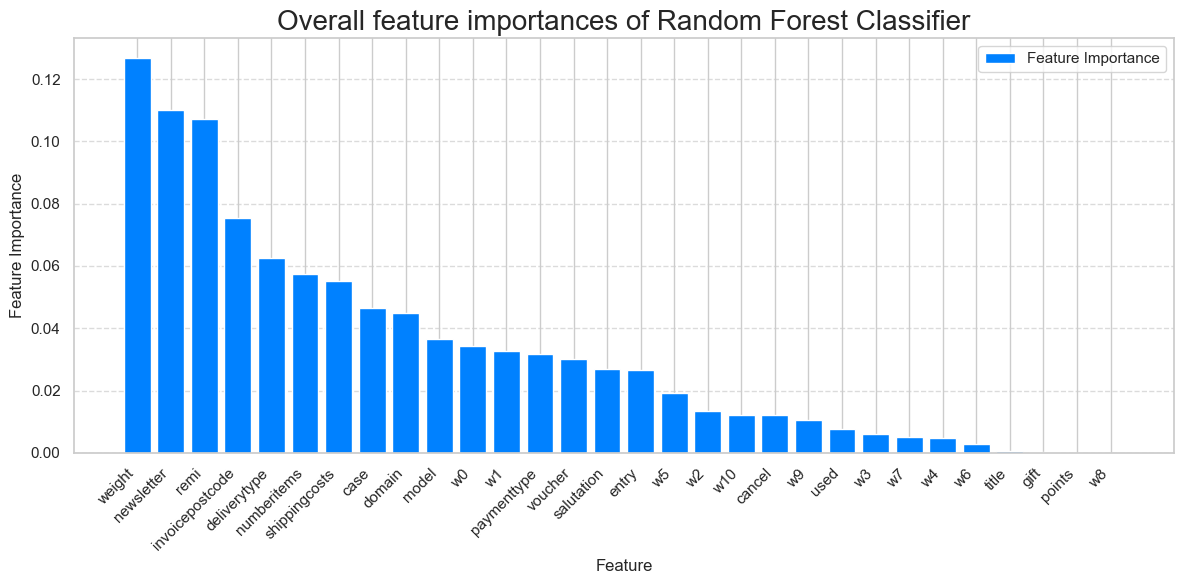

In [78]:
# Set model to best estimator from CV
model = forest_cv2.best_estimator_

# Sort feature importances in descending order
sorted_indices = np.argsort(model.feature_importances_)[::-1]
srtd = model.feature_importances_[sorted_indices]

# Plot feature importance
fig = plt.figure(figsize=(12, 6))
ax = fig.gca() #get current axis
ax.bar(range(x_train.shape[1]), srtd, color = "#0081ff", width = 0.8)
ax.set_xticks(np.arange(x_train.shape[1]))
ax.set_xticklabels([f'{x_train.columns[col]}' for col in sorted_indices], rotation=45, ha='right')
ax.set_xlabel('Feature', fontsize = 12)
ax.set_ylabel('Feature Importance', fontsize = 12)
ax.set_title('Overall feature importances of Random Forest Classifier', fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(['Feature Importance'])
plt.tight_layout()


The graph above shows the overall feature importance of our best-performing Random Forest model. The importance of a feature is determined by how much it helps the algorithm achieve its goal of minimizing a certain measure. It can be computed by going through all splits on which a feature is used at the split criterion and compute the reduction in error compared to the previous node. 

According to this approach, our **10 most important features** are:
- Weight
- Newsletter
- Remi
- Invoicepostcode
- Deliverytype
- Numberitems
- Shippingscosts
- Case
- Domain
- Model

- Permutation feature importance

In [79]:
# Set list of metrics to compute feature importance for
metrics = ['accuracy', 'precision', 'recall', 'f1'] # specificity not a valid scoring metric
# Initialize empty dictionary to store results
pfi_scores = {}
# Loop over all metrics
for metric in metrics:
    print('Computing permutation importance with {0}...'.format(metric))
    pfi_scores[metric] = permutation_importance(model, x_test, y_test, scoring = metric, n_repeats = 30, random_state = seed)

Computing permutation importance with accuracy...


Computing permutation importance with precision...
Computing permutation importance with recall...
Computing permutation importance with f1...


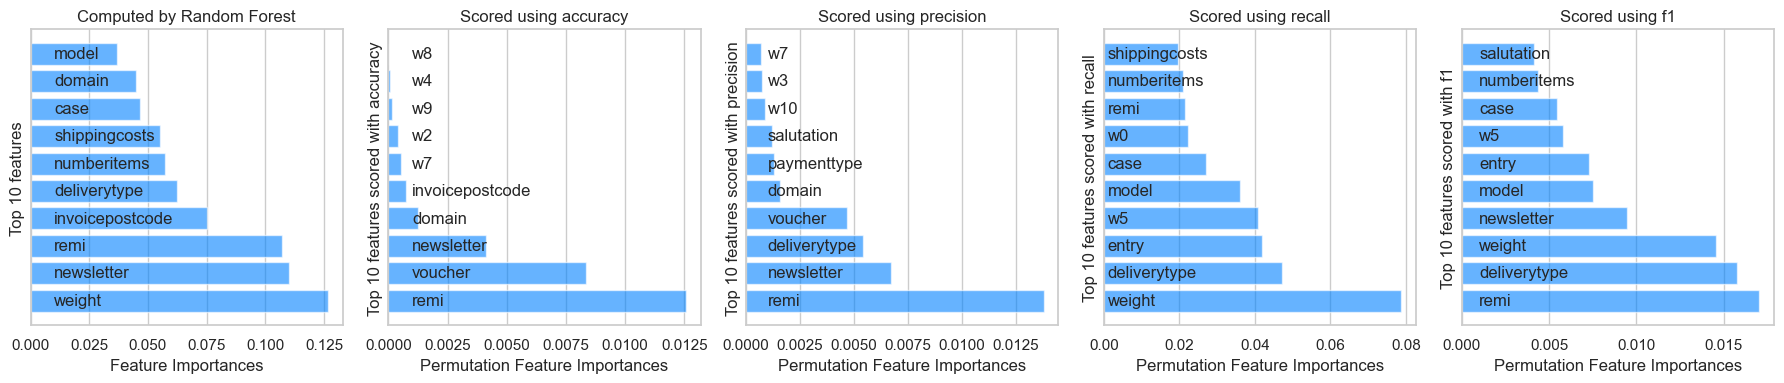

In [110]:
# Visualization of results
features = x_test.columns.values
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (18, 4))

scores = model.feature_importances_
features = x_test.columns.to_numpy()
srtd = np.argsort(-scores) # sort descending and get indices

top = 10 # Top 10 features
ax[0].barh(y = np.arange(0, top), width=scores[srtd[:top]], color='#0081ff', alpha = 0.6) # regular feature importance of RF
for i in range(top):
    ax[0].text(0.01, i-0.15, features[srtd[i]]) # add feature names to plot
ax[0].set_yticks([])
ax[0].set_ylabel('Top {0} features'.format(top));
ax[0].set_xlabel('Feature Importances')
ax[0].set_title('Computed by Random Forest')

for k, metric in enumerate(metrics):
    scores = pfi_scores[metric]['importances_mean']
    srtd = np.argsort(-scores)

    ax[k+1].barh(y=np.arange(0, top), width = scores[srtd[:top]], color = '#0081ff', alpha = 0.6)
    for i in range(top):
        ax[k+1].text(0.001, i-0.15, features[srtd[i]])
    ax[k+1].set_yticks([])
    ax[k+1].set_ylabel('Top {0} features scored with {1}'.format(top, metric));
    ax[k+1].set_xlabel('Permutation Feature Importances')
    ax[k+1].set_title('Scored using {0}'.format(metric))
plt.savefig("perm_feature_importance.png")
plt.tight_layout()

Permutation feature importance measures the reduction in a model's performance when the values of a particular feature are randomly shuffled. \
However, the scoring criterion used in the estimation process varies. 
This allows us to gain insights on how the importance of a feature might change according to the different scoring measures.

- Top 5 features, when using *accuracy* as a scoring measure:
    - Remi
    - Voucher
    - Newsletter
    - Domain
    - Invoicepostcode
- Top 5 features, when using *precision* as scoring measure: 
    - Remi
    - Newsletter 
    - Deliverytype
    - Voucher
    - Domain
- Top 5 features, when using *recall* as scoring measure:
    - Weight
    - Deliverytype
    - Entry
    - W5 (Number of)
    - Model
- Top 5 features, when using the *F1-score* as scoring measure:
    - Remi
    - Deliverytype
    - Weight
    - Newsletter
    - Model

##### Global model agnostic methods

- Partial dependence plots

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


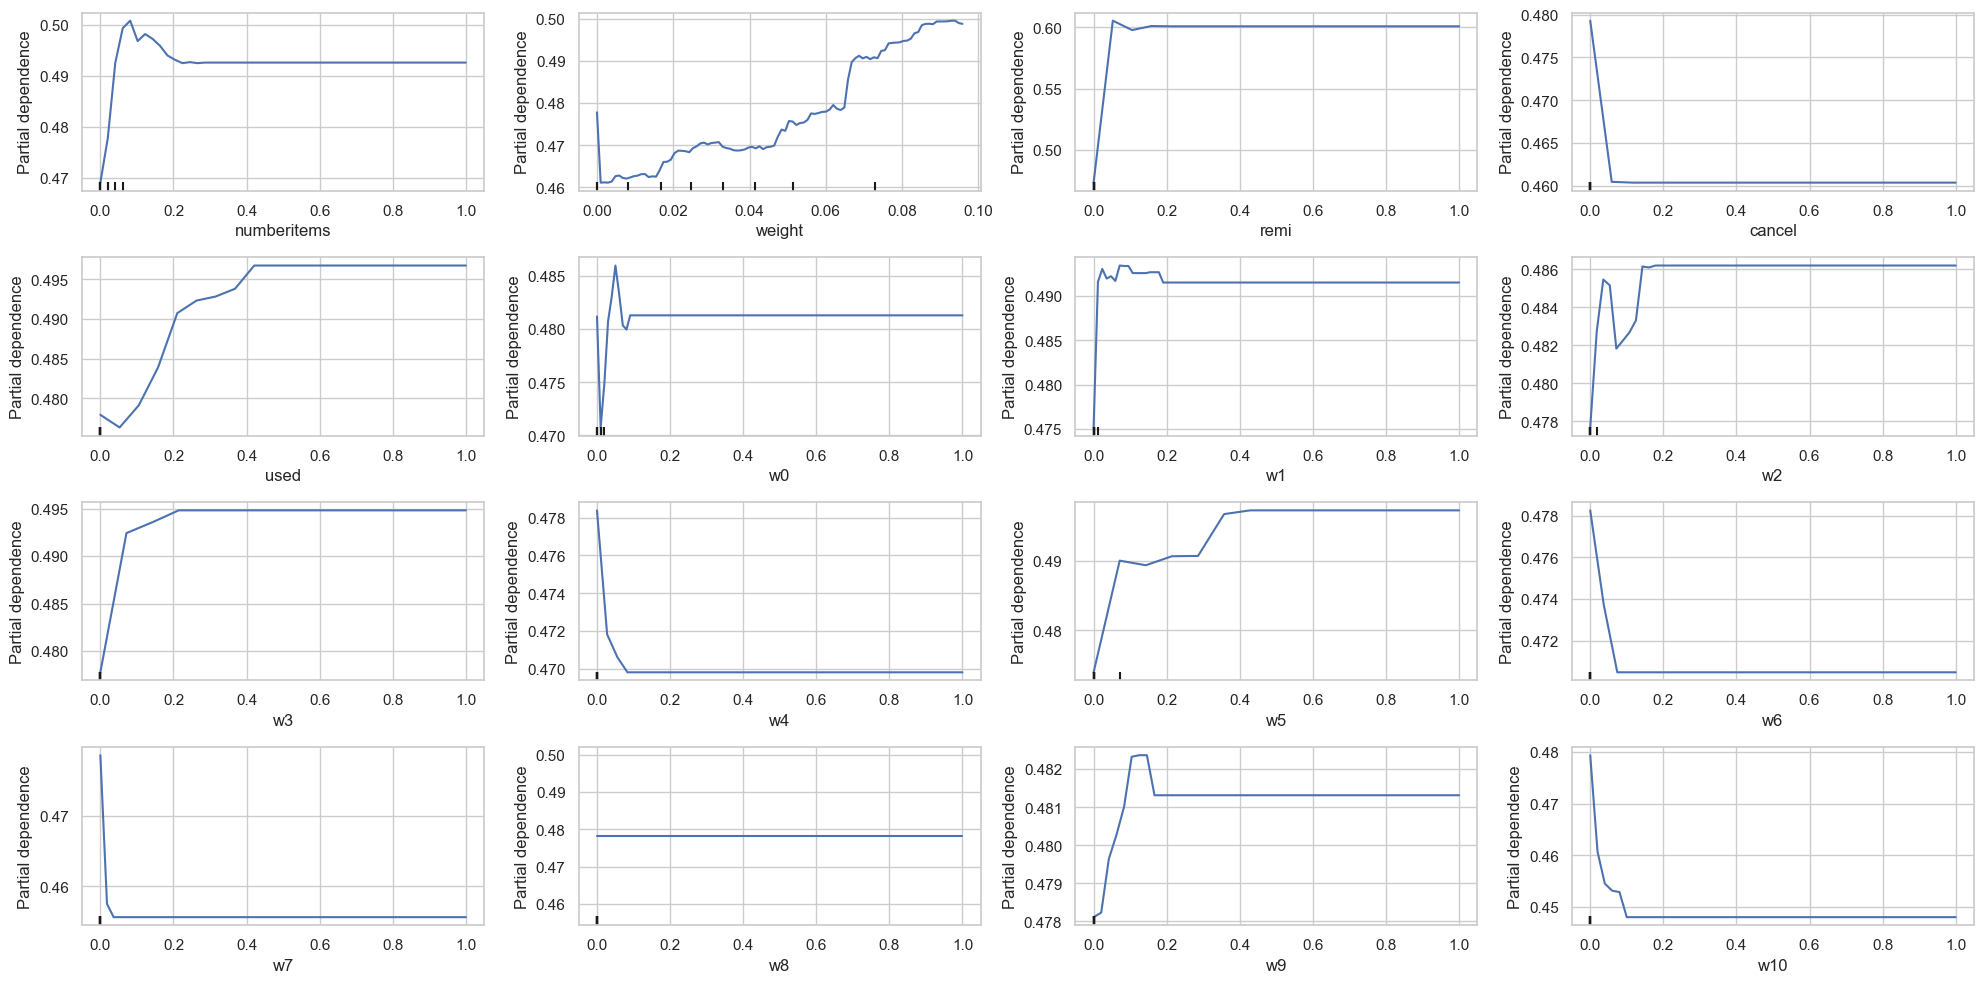

In [81]:
# Continuous features
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))

# Iterate through both features and axes
for feature, axis in zip(cntnous_features, ax.flatten()):
    pdp.from_estimator(forest_cv2.best_estimator_, x_train,
                       features=[feature],  # Use only one feature at a time
                       feature_names=list(x_train.columns),
                       kind='average',
                       response_method = "predict_proba", # Use predict_proba to get probability of class 1
                       ax=axis)

    # Set the title for each subplot
    # axis.set_title(feature, fontsize = 12)

plt.tight_layout()
plt.show()

The graphs above show the partial dependence plots of all continuous features in our data set. In order to compute a partial dependence plot, the values of the feature of interest are set to 0, while holding every other variable constant. Afterwards, the predicted values are computed and the same process is repeated by setting the feature of interest to 1,2,... . \
This procedure helpts isolate the marginal effect one specific feature can have on the outcome. \
If we for example take a closer look on the *weight* feature, we can see that with an increasing weight (more items ordered) a potential re-purchase becomes more likely. \
  On the other hand, *w8* (Number of hardware items ordered) does not seem to have a considerable influence on the outcome variable.

- Global surrogate model

More complex Machine Learning models often come with better performances. However, they often lack an easy interpretation. \
 Therefore, global surrogate models can act as a way of approximating the (more precise) predictions of an elaborate Machine Learning model, while still being rather easy to understand and interpret. 

In [82]:
# Compute the model
yb_train_pred = forest_cv2.predict(x_train)  # Training set predictions of the black-box (RF) model
yb_test_pred = forest_cv2.predict(x_test)  # Test set predictions of the black-box (RF) model

acc={}

# Loop over max_depth
depth_limits = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for max_depth in depth_limits:
    print('Surrogate max-depth = {0}'.format(max_depth))
    surrogate = DecisionTreeClassifier(max_depth = max_depth, criterion = 'gini',
                                       min_samples_leaf = 20, class_weight = 'balanced', random_state = seed)
    surrogate.fit(x_train, yb_train_pred)
    ys_train_pred = surrogate.predict(x_train)
    ys_test_pred = surrogate.predict(x_test)

    acc[max_depth] = {'trn': {'black-box': accuracy_score(y_train, yb_train_pred),
                                   'surrogate': accuracy_score(y_train, ys_train_pred),
                                   'r2': r2_score(yb_train_pred, ys_train_pred)},
                           'tst': {'black-box': accuracy_score(y_test, yb_test_pred),
                                   'surrogate': accuracy_score(y_test, ys_test_pred),
                                   'r2': r2_score(yb_test_pred, ys_test_pred)}} # r_squared as in regression

Surrogate max-depth = 2
Surrogate max-depth = 3
Surrogate max-depth = 4
Surrogate max-depth = 5
Surrogate max-depth = 6
Surrogate max-depth = 7
Surrogate max-depth = 8
Surrogate max-depth = 9
Surrogate max-depth = 10


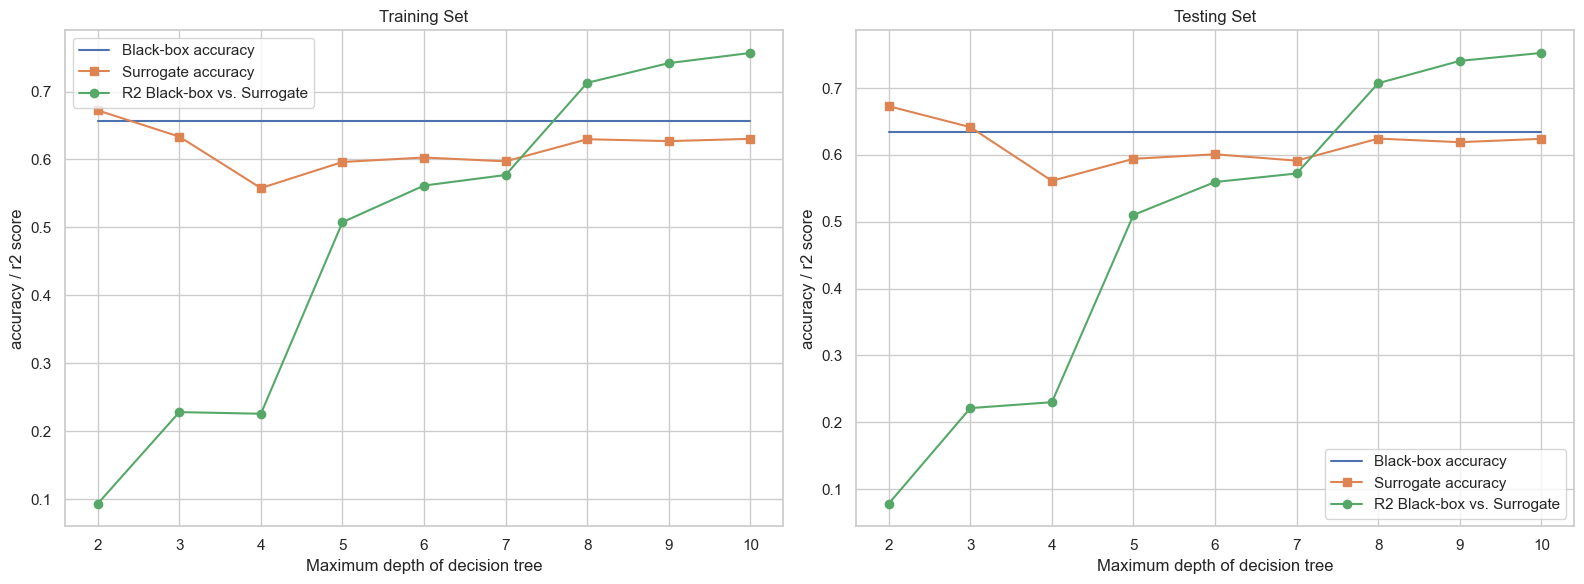

In [83]:
# Visualization of results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

fig_labels = ['Training Set', 'Testing Set']
markers = [None, 's', 'o']
for i, dset in enumerate(['trn', 'tst']):
    for j, curve in enumerate(['black-box', 'surrogate', 'r2']):
        z = [acc[mleaf][dset][curve] for mleaf in depth_limits]
        ax[i].plot(depth_limits, z, marker=markers[j])
    ax[i].legend(['Black-box accuracy', 'Surrogate accuracy', 'R2 Black-box vs. Surrogate'])
    ax[i].set_title(fig_labels[i])
    ax[i].set_xlabel('Maximum depth of decision tree')
    ax[i].set_ylabel('accuracy / r2 score')
    ax[i].set_xticks(depth_limits)
plt.tight_layout()

Visual inspection of the graphs above suggests that a maximum depth of 5 seems to be an adequate parameter value. Here, the model performs well enough while still being rather easy to interpret. \
When increasing the maximum depth of the decision tree from 4 to 5 a considerable improvement in the surrogate's accuracy can be achieved. Afterwards, increasing the depth further only leads to minor improvements in the model's performance. \
When increasing the maximum depth of the decision tree from 7 to 8 we could also considerably improve the surrogate's accuracy. However, at this point the model already gets rather complex und future predictions will be harder to comprehend. \
 Therefore, 5 appears to be the optimal depth where this trade-off between performance and traceability of the model is well balanced.

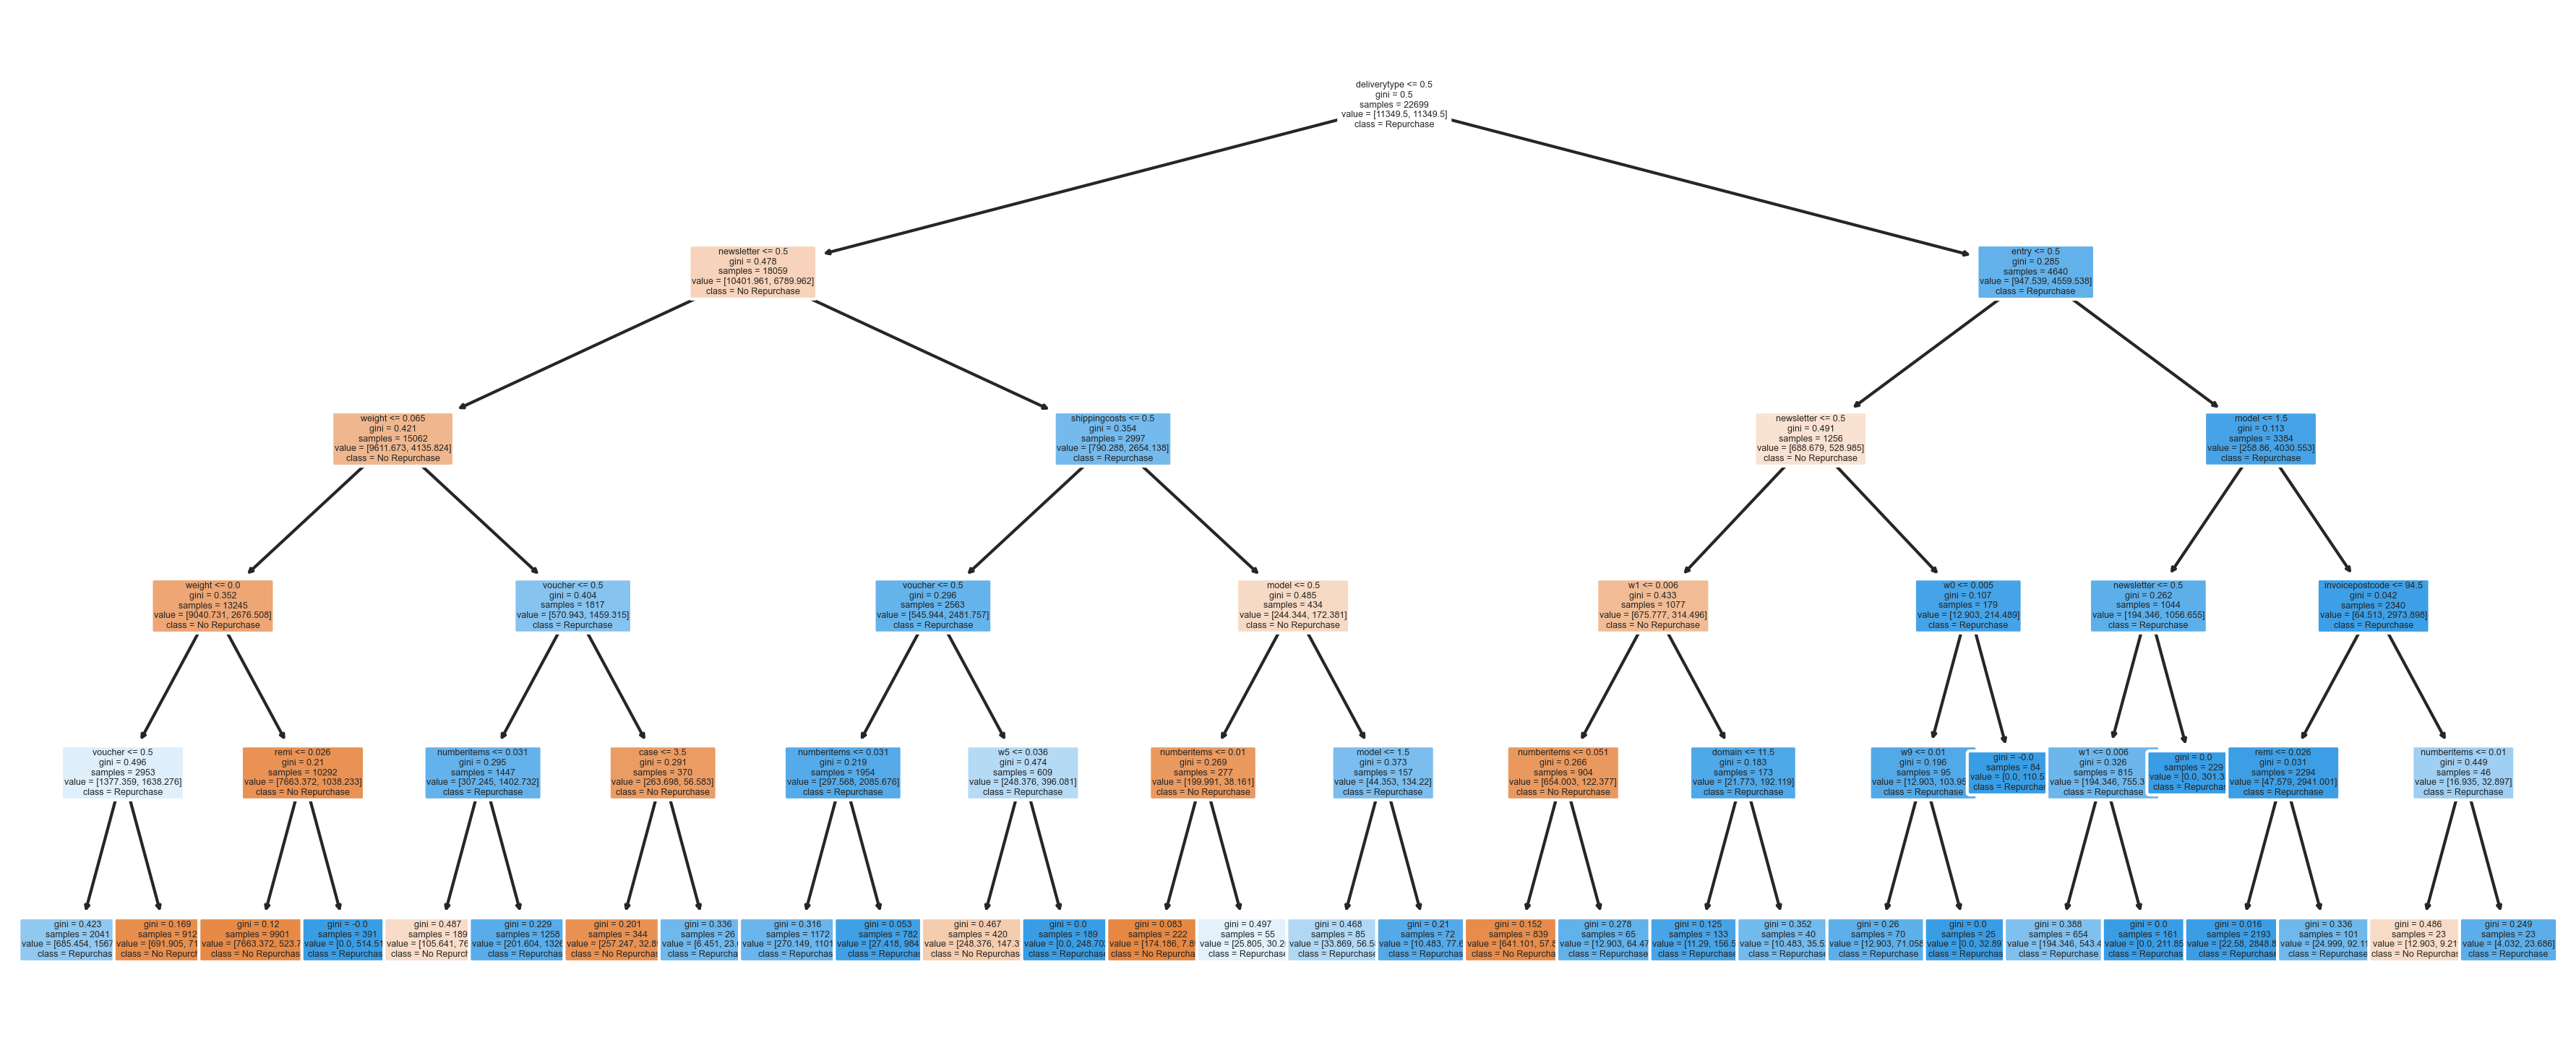

In [84]:
# Set up surrogate model as decision tree with max_depth = 6
surrogate = DecisionTreeClassifier(max_depth = 5, criterion = 'gini', min_samples_leaf = 20, class_weight = 'balanced', random_state = seed)
surrogate.fit(x_train, yb_train_pred)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6), dpi=300)
ax = fig.gca()
plot_tree(surrogate, fontsize = 3, feature_names = x_train.columns.values,
          rounded=True, filled=True, ax = ax, class_names = ["No Repurchase", "Repurchase"]) # in order of surrogate.classes_
fig.savefig('Regression Tree.PNG')

The graph above simply illustrates how our surrogate operates.

##### Local model agnostic methods (LIME)

- Explain one prediction instance of our trained model

In [85]:
cat_idx = np.array([cat_features.index(f) for f in cat_features])


lime_explainer = lime_tabular.LimeTabularExplainer(x_train.values,
                                              feature_names=list(x_train.columns),
                                              class_names=['No purchase', 'Repurchase'],
                                              categorical_features=cat_idx,
                                              kernel_width=75.0,
                                              categorical_names=cat_features,
                                              discretize_continuous=False)

In [103]:
# Explain a single instance using example index:
exp = lime_explainer.explain_instance(x_test.iloc[303], forest_cv2.predict_proba)
exp.show_in_notebook(show_table=False, show_all=False)
# Save explanation to html file
exp.save_to_file('lime_explanation.html')

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


LIME is a technique used to interpret the predictions of machine learning models, providing insights into the model's decision-making process for specific instances. LIME generates locally faithful explanations by approximating the model's behavior around a particular instance with a simpler, interpretable model. Using this approach, we can approximate individual predictions as well the top 10 features that have the most influence on the models' prediction for the selected instance. 

For the observation with index 303, LIME predicts the probability of the individual repurchasing within 90 days as 34%. This rather small probability can (in parts) be attributed to the individual not being subscribed to the newsletter and having to pay shipping costs. 

- Shapley values

In [88]:
shap_explainer = shap.Explainer(forest_cv2.best_estimator_)
shap_values = shap_explainer.shap_values(x_test)

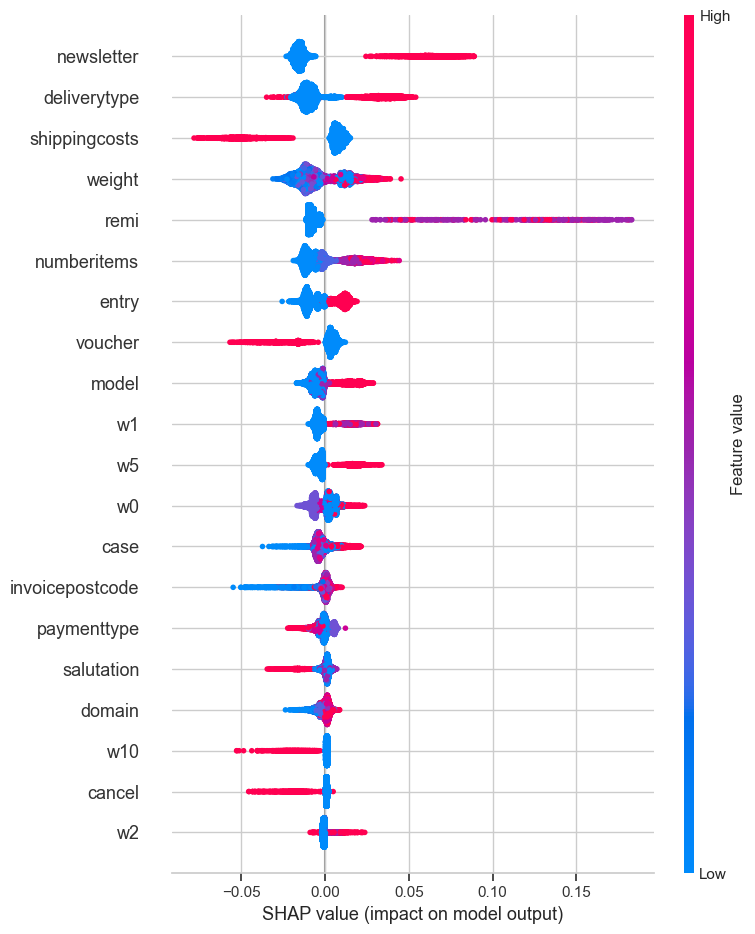

<Figure size 640x480 with 0 Axes>

In [111]:
shap.summary_plot(shap_values[1], x_test) # shap_vales[label]
# Save the SHAP summary plot

Shapley values can be used to explain the output of any Machine Learning Model using a Game Theory approach. This way we can capture each variable's influence on the model prediction. We are able to not only capute how a feature affects the final prediction, but also directly compare it to the influence of other features. Higher values, as captured in red, symbolize higher values in the underlying features. Furthermore, their placing along the x-axis signals the direction of the feature's influence on the models output. 

Here, we plotted the summary plot of shapley values for the **label 1**. 
Meaning that if we for example take a closer look at the *newsletter* variable, we can see that higher values in the feature will push the model output towards a higher label as well. 

In the underlying example of customers repurchasing withing a certain time limit and *newsletter* being a binary variable with 1 signaling an active subscription, we can deduce that people who are subscribed to the newsletter are more likely to repurchase within the given limit of 90 days.


If we were to flip the summary plot and instead plot the feature's influence on the model predicting an outcome of 0, the graph would be flipped.